In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Read in Data and Split


In [4]:
test_data, train_data = pd.read_csv('fhs_test.csv'), pd.read_csv('fhs_train.csv')
data = pd.concat([test_data, train_data])

num_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
cat_vars = ['sex', 'education', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [30]:
data.head()

,Unnamed: 0,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,674,0,58,1.0,1,20.0,0.0,0,0,0,NaN,126.0,77.0,30.08,78.0,NaN,0
1,4070,0,51,3.0,0,0.0,0.0,0,0,0,264.0,135.0,83.0,26.68,60.0,74.0,0
2,3150,0,44,2.0,1,9.0,0.0,0,1,0,NaN,147.5,96.0,30.57,78.0,NaN,1
3,1695,0,40,2.0,1,20.0,0.0,0,0,0,271.0,138.5,88.0,27.24,80.0,NaN,1
4,2692,1,58,2.0,1,20.0,0.0,0,0,0,207.0,110.0,80.0,23.55,78.0,78.0,0


### Analyze how the data correlates with CHD by categorical and numeric data

In [77]:
def desc_data(var):
    return data.loc[:, [var, 'TenYearCHD']].groupby('TenYearCHD').describe()

def find_diff(var):
    return data.groupby('TenYearCHD')[var].mean().diff().iloc[-1]

In [88]:
diff_numeric_data = {}

for var in num_vars:
    print(desc_data(var))
    diff_numeric_data[var] = find_diff(var)

dict(sorted(diff_numeric_data.items(), key=lambda item: -item[1]))

               age                                                   
             count       mean       std   min   25%   50%   75%   max
TenYearCHD                                                           
0           3596.0  48.762514  8.413963  32.0  42.0  48.0  55.0  70.0
1            644.0  54.145963  8.005663  35.0  48.0  55.0  61.0  70.0
           cigsPerDay                                                 
                count       mean        std  min  25%  50%   75%   max
TenYearCHD                                                            
0              3569.0   8.713925  11.694865  0.0  0.0  0.0  20.0  70.0
1               642.0  10.629283  13.006645  0.0  0.0  2.5  20.0  60.0
           totChol                                                          
             count        mean        std    min    25%    50%    75%    max
TenYearCHD                                                                  
0           3555.0  235.147398  43.765750  113.0  205.0  232.0  

{'sysBP': 13.281469576271775,
 'totChol': 10.241578347010432,
 'glucose': 8.329166434138813,
 'age': 5.383448828581095,
 'diaBP': 4.814931531929886,
 'cigsPerDay': 1.9153580197774378,
 'BMI': 0.8597923363284323,
 'heartRate': 0.7678126897520485}

`^ shows the most significant indicators of CHD by purely the difference in numeric values`

In [87]:
diff_categorical_data = {}

for var in cat_vars:
    print(desc_data(var))
    diff_categorical_data[var] = find_diff(var)

dict(sorted(diff_categorical_data.items(), key=lambda item: -item[1]))

               sex                                             
             count      mean       std  min  25%  50%  75%  max
TenYearCHD                                                     
0           3596.0  0.410734  0.492035  0.0  0.0  0.0  1.0  1.0
1            644.0  0.532609  0.499323  0.0  0.0  1.0  1.0  1.0
           education                                             
               count      mean       std  min  25%  50%  75%  max
TenYearCHD                                                       
0             3507.0  2.002851  1.014719  1.0  1.0  2.0  3.0  4.0
1              628.0  1.848726  1.038823  1.0  1.0  1.0  3.0  4.0
            BPMeds                                             
             count      mean       std  min  25%  50%  75%  max
TenYearCHD                                                     
0           3554.0  0.023354  0.151046  0.0  0.0  0.0  0.0  1.0
1            633.0  0.064771  0.246316  0.0  0.0  0.0  0.0  1.0
           prevalentStroke    

{'prevalentHyp': 0.2287963161276505,
 'sex': 0.12187454659766894,
 'diabetes': 0.04292381459040065,
 'BPMeds': 0.041416964708789944,
 'prevalentStroke': 0.013187530658633817,
 'education': -0.154125325327507}

`prevalentHyp` - Hyp prevalence is positively correlated with CHD

`sex` - males more likely to have CHD

`diabetes` - diabetes is positively correlated with CHD

`BPMeds` - blood pressure medications are positively correlated with CHD

`prevalentStroke` - strokes are positively correlated with CHD

`education` - Higher Education is positively correlated with CHD

### Pipelining Shenanigans with every single variable

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.linear_model import LinearRegression

In [105]:
test_data, train_data = pd.read_csv('fhs_test.csv'), pd.read_csv('fhs_train.csv')
data = pd.concat([test_data, train_data])

y = 'TenYearCHD'
cat_vars = ['sex', 'education', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
num_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
X_vars = cat_vars + num_vars

In [106]:
cat_pipeline = Pipeline(steps = [('ohc', OneHotEncoder(sparse_output=False))])
num_pipeline = Pipeline(steps = [('maxmin', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

In [107]:
#column transformer
preprocessor = ColumnTransformer(transformers = [('cat', cat_pipeline, cat_vars), ('num', num_pipeline, num_vars)])

In [108]:
lm_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('linreg', LinearRegression(fit_intercept=False))])
tree_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('tree', DecisionTreeRegressor(max_depth = 6))])

Linear Model rsq:  0.08736423902541657
sex: -2138080833440.4568
education: -2138080833440.376
BPMeds: -559131180679.964
prevalentStroke: -559131180679.9923
prevalentHyp: -559131180679.9786
diabetes: -559131180679.9706
age: -559131180680.0298
cigsPerDay: -1199558190427.1997
totChol: -1199558190427.136
sysBP: -1199558190427.1194
diaBP: 7629400177055.803
BMI: 7629400177055.903
heartRate: -881778545473.6825
glucose: -881778545473.6593

Tree rsq:  -0.02243805524274345


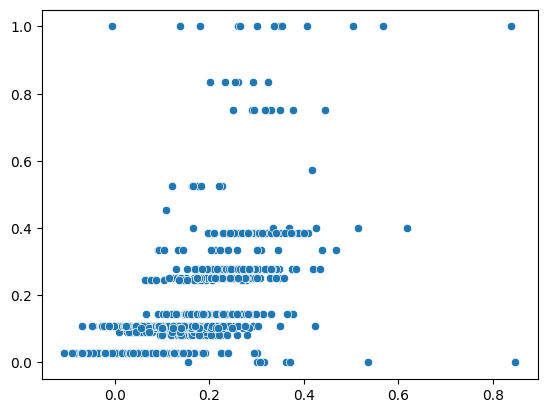

In [109]:
X_train = train_data.loc[:, train_data.columns!= y]
X_test = test_data.loc[:, test_data.columns!= y]

lm = lm_pipe.fit(X_train, train_data[y])
tree = tree_pipe.fit(X_train, train_data[y])

print('Linear Model rsq: ', lm.score(X_test, test_data[y]))  # R-squared
coefs = lm.named_steps['linreg'].coef_
for var, coef in zip(X_vars, coefs):
    print(f"{var}: {coef}")
y_hat_lm = lm.predict(X_test) # Predicted values
print()

print('Tree rsq: ', tree.score(X_test, test_data[y]) ) # R-squared
y_hat_tree = tree.predict(X_test) 


sns.scatterplot(x=y_hat_lm, y=y_hat_tree)
plt.show()